# Test NE peak frequency assignment
In which we attempt to determine if the pre/post effects that we observe for context regression are robust or just a product of data problems. Why is it that assigning random peak dates doesn't give us random noise results?

In [1]:
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

## Load data

In [2]:
import dateutil
from datetime import datetime
# load full data
full_data = pd.read_csv('../../data/mined_tweets/combined_tweet_tag_data.gz', sep='\t', index_col=False, compression='gzip', converters={'date' : dateutil.parser.parse})
# load anchor data
anchor_data = pd.read_csv('../../data/mined_tweets/combined_tweet_tag_data_NE_flat_parsed_anchor.gz', sep='\t', index_col=False, compression='gzip', converters={'date' : dateutil.parser.parse})
# fix bad usernames
anchor_data = anchor_data.assign(**{'username' : anchor_data.loc[:, 'username'].apply(lambda x: x.split(':')[-1])})
from datetime import datetime
def fix_timezone(x, date_fmt='%Y-%m-%d %H:%M:%S', timezone_str='+0000'):
    # add timezone offset for "naive" dates
    if(x.utcoffset() is None):
        x = datetime.strptime('%s%s'%(x.strftime(date_fmt), timezone_str), '%s%%z'%(date_fmt))
    return x
date_var = 'date'
full_data = full_data.assign(**{date_var : full_data.loc[:, date_var].apply(lambda x: fix_timezone(x))})
anchor_data = anchor_data.assign(**{date_var : anchor_data.loc[:, date_var].apply(lambda x: fix_timezone(x))})
## add time var
from datetime import datetime
def round_to_day(x):
    x_day = datetime(day=x.day, month=x.month, year=x.year)
    return x_day
round_date_var = '%s_day'%(date_var)
full_data = full_data.assign(**{round_date_var : full_data.loc[:, date_var].apply(lambda x: round_to_day(x))})
anchor_data = anchor_data.assign(**{round_date_var : anchor_data.loc[:, date_var].apply(lambda x: round_to_day(x))})

## Detect peak times

Let's do this the right way:

1. Compute NE frequency at each time step for each data set
    NE | count | time | data
2. Normalize by total docs at each time step for each data set
    NE | freq | time | data
3. Visualize some time series for NEs
4. Detect peaks with argmax
5. Sanity check on visual time series

In [3]:
NE_var = 'NE_fixed'
round_date_var = 'date_day'
data_name_var = 'data_name_fixed'
NE_counts = anchor_data.groupby([NE_var, data_name_var, round_date_var]).apply(lambda x: x.shape[0]).reset_index().rename(columns={0 : 'NE_count'})
display(NE_counts.head())

,NE_fixed,data_name_fixed,date_day,NE_count
0,abbeville,harvey,2017-08-28,1
1,abbeville,irma,2017-09-07,1
2,abbeville,irma,2017-09-08,1
3,abbeville,irma,2017-09-12,1
4,abbeville county,irma,2017-09-10,1


In [4]:
id_var = 'id'
doc_counts = full_data.groupby([data_name_var, round_date_var]).apply(lambda x: x.loc[:, id_var].nunique()).reset_index().rename(columns={0 : 'doc_count'})
display(doc_counts.head())

,data_name_fixed,date_day,doc_count
0,florence,2018-08-29,2
1,florence,2018-08-30,10
2,florence,2018-08-31,5
3,florence,2018-09-01,36
4,florence,2018-09-02,17


In [5]:
NE_doc_counts = pd.merge(NE_counts, doc_counts, on=[data_name_var, round_date_var])
NE_doc_counts = NE_doc_counts.assign(**{'NE_freq' : NE_doc_counts.loc[:, 'NE_count'] / NE_doc_counts.loc[:, 'doc_count']})

In [6]:
display(NE_doc_counts.head())

,NE_fixed,data_name_fixed,date_day,NE_count,doc_count,NE_freq
0,abbeville,harvey,2017-08-28,1,98079,0.000010
1,abbott,harvey,2017-08-28,14,98079,0.000143
2,abilene,harvey,2017-08-28,8,98079,0.000082
3,addicks,harvey,2017-08-28,20,98079,0.000204
4,africa,harvey,2017-08-28,14,98079,0.000143


Restrict to consistent NEs, i.e. that appear on at least $k$ unique dates.

In [7]:
k_consistent = 5
# k_consistent = 10
NE_unique_date_counts = NE_doc_counts.groupby([data_name_var, NE_var]).apply(lambda x: x.loc[:, round_date_var].nunique())
NE_consistent = NE_unique_date_counts[NE_unique_date_counts >= k_consistent].reset_index().loc[:, [data_name_var, NE_var]]
print(NE_consistent.head())
NE_doc_counts_consistent = pd.merge(NE_doc_counts, NE_consistent, on=[data_name_var, NE_var], how='inner')
print('%d/%d consistent counts'%(NE_doc_counts_consistent.shape[0], NE_doc_counts.shape[0]))


  data_name_fixed      NE_fixed
0        florence         alert
1        florence  anson county
2        florence          apex
3        florence     asheville
4        florence       atlanta
11902/19746 consistent counts


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


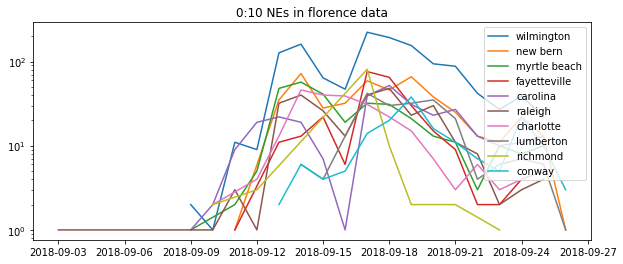

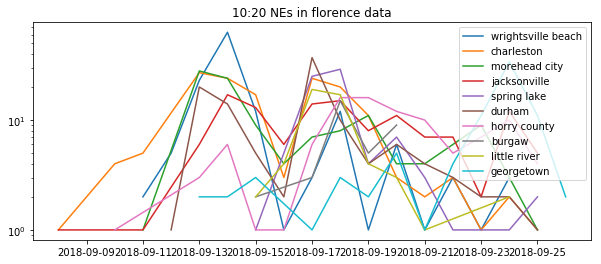

/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


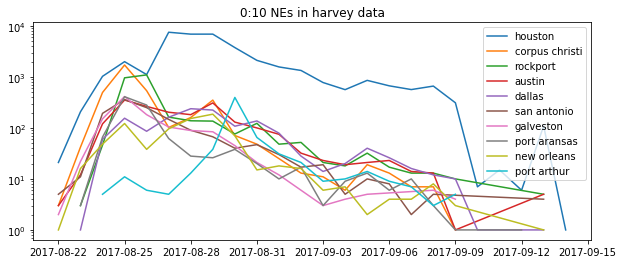

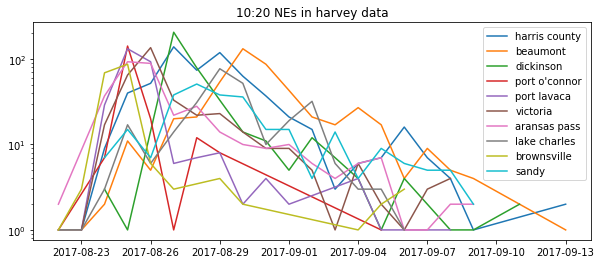

/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


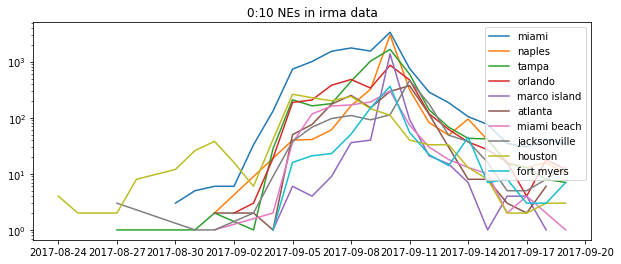

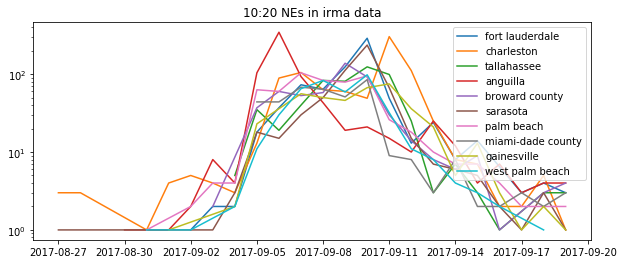

/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


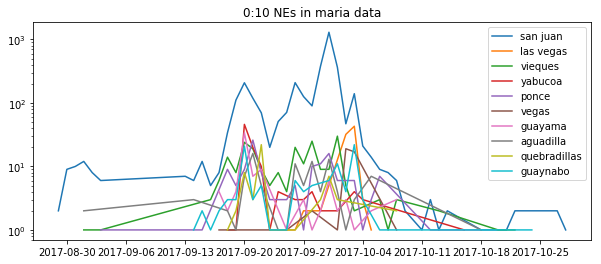

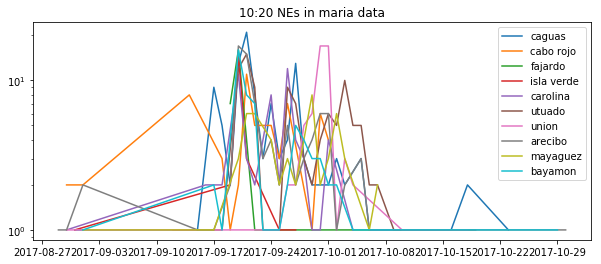

/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


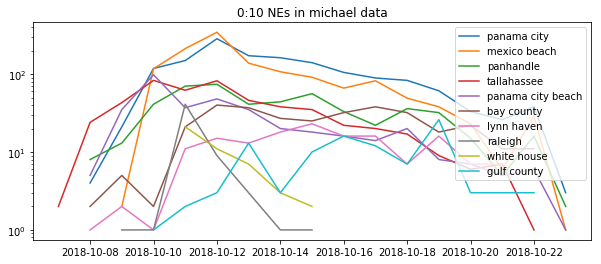

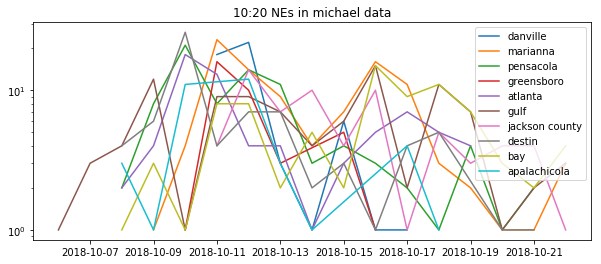

In [219]:
freq_var = 'NE_count'
# NE_mean_freq = NE_doc_counts.groupby([data_name_var, NE_var]).apply(lambda x: x.loc[:, freq_var].mean()).sort_values(ascending=False)
top_k = 10
K = 20
top_k_sets = int(K / top_k)
smooth_freq = 1e-5
for data_name_i, data_i in NE_doc_counts_consistent.groupby(data_name_var):
    data_i.sort_values(round_date_var, inplace=True, ascending=True)
    NE_mean_freq = data_i.groupby(NE_var).apply(lambda x: x.loc[:, freq_var].mean()).sort_values(ascending=False)
    ## top_k_sets sets of top-k words (more variety = better?)
    for top_k_ctr in range(top_k_sets):
        top_k_lower, top_k_upper = (top_k_ctr*top_k, (top_k_ctr+1)*top_k)
        plt.figure(figsize=(10,4))
        for NE_k in NE_mean_freq.index[top_k_lower:top_k_upper]:
            NE_doc_counts_k = data_i[data_i.loc[:, NE_var] == NE_k]
            plt.plot(NE_doc_counts_k.loc[:, round_date_var], NE_doc_counts_k.loc[:, freq_var], label=NE_k)
        plt.legend(loc='upper right')
        plt.title('%d:%d NEs in %s data'%(top_k_lower, top_k_upper, data_name_i))
        plt.yscale('log')
        plt.show()
#     plt.figure(figsize=(10,4))
#     for k, NE_k in enumerate(NE_mean_freq.index[:top_k]):
#         NE_doc_counts_k = data_i[data_i.loc[:, NE_var] == NE_k]
#         plt.plot(NE_doc_counts_k.loc[:, round_date_var], NE_doc_counts_k.loc[:, freq_var], label=NE_k)
#     plt.legend(loc='upper right')
#     plt.title('top-%d NEs in %s data'%(top_k, data_name_i))
#     plt.yscale('log')
#     plt.show()

Same thing but with normalized frequency.

/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


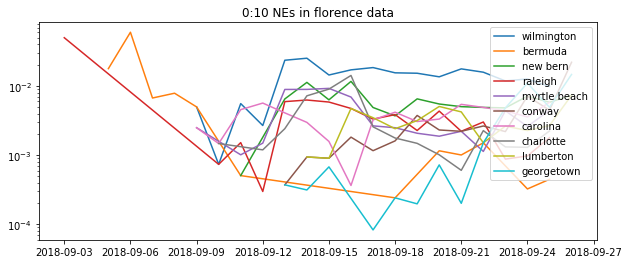

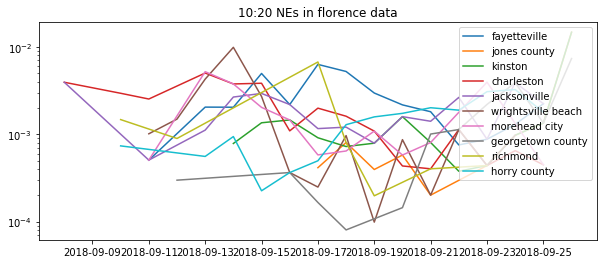

/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


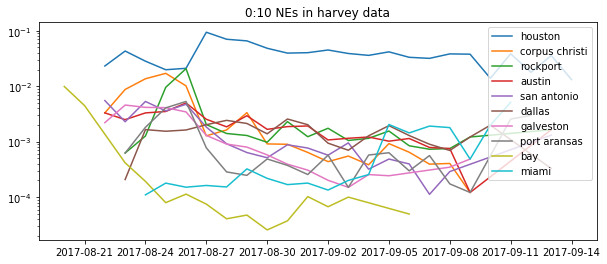

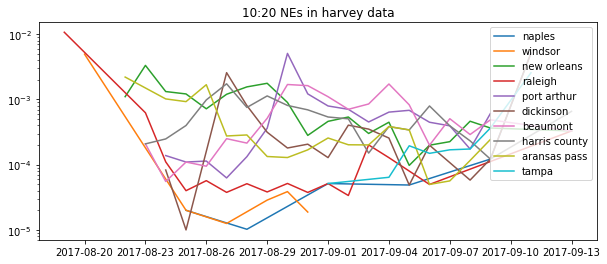

/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


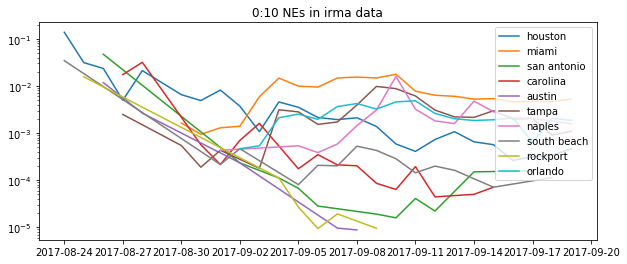

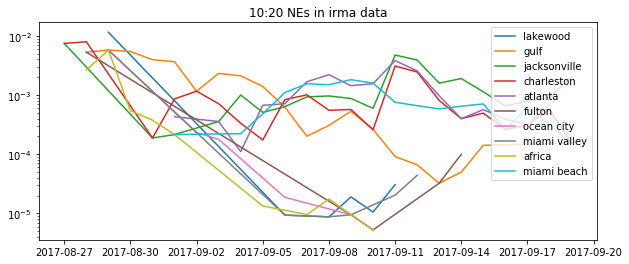

/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


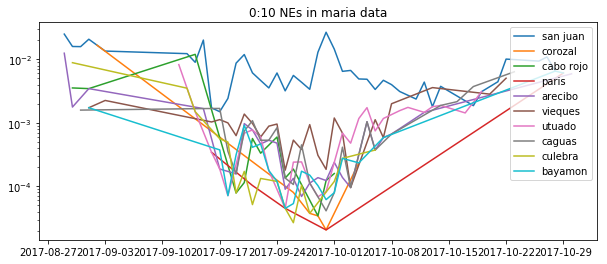

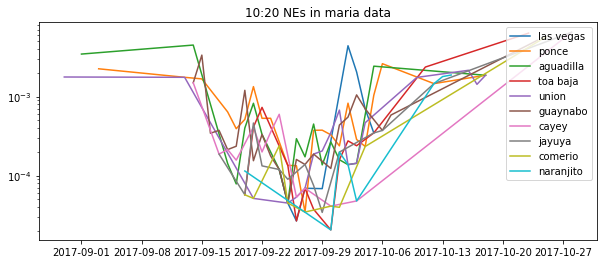

/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


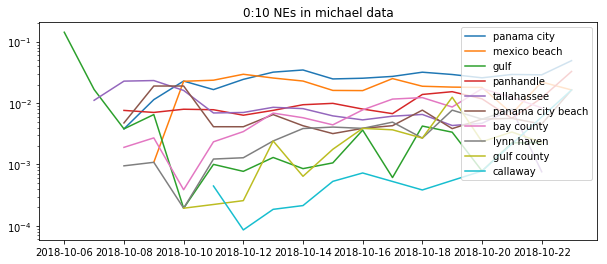

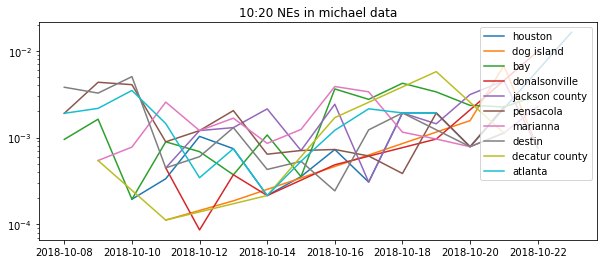

In [220]:
freq_var = 'NE_freq'

# per-day norm freq
# NE_mean_freq = NE_doc_counts.groupby([data_name_var, NE_var]).apply(lambda x: x.loc[:, freq_var].mean()).sort_values(ascending=False)

# overall norm freq
docs_per_data = doc_counts.groupby(data_name_var).apply(lambda x: x.loc[:, 'doc_count'].sum())
# NE_mean_freq = NE_doc_counts.groupby([data_name_var, NE_var]).apply(lambda x: x.loc[:, freq_var] / docs_per_data.loc[x.loc[:, data_name_var].iloc[0]]).sort_values(ascending=False)
top_k = 10
smooth_freq = 1e-5
for data_name_i, data_i in NE_doc_counts_consistent.groupby(data_name_var):
    data_i.sort_values(round_date_var, inplace=True, ascending=True)
    NE_mean_freq = data_i.groupby(NE_var).apply(lambda x: x.loc[:, freq_var].mean()).sort_values(ascending=False)
    ## top_k_sets sets of top-k words (more variety = better?)
    for top_k_ctr in range(top_k_sets):
        top_k_lower, top_k_upper = (top_k_ctr*top_k, (top_k_ctr+1)*top_k)
        plt.figure(figsize=(10,4))
        for NE_k in NE_mean_freq.index[top_k_lower:top_k_upper]:
            NE_doc_counts_k = data_i[data_i.loc[:, NE_var] == NE_k]
            plt.plot(NE_doc_counts_k.loc[:, round_date_var], NE_doc_counts_k.loc[:, freq_var], label=NE_k)
        plt.legend(loc='upper right')
        plt.title('%d:%d NEs in %s data'%(top_k_lower, top_k_upper, data_name_i))
        plt.yscale('log')
        plt.show()
        
    ## top-k words (less variety = simpler)
#     plt.figure(figsize=(10,4))
#     for k, NE_k in enumerate(NE_mean_freq.index[:top_k]):
#         NE_doc_counts_k = data_i[data_i.loc[:, NE_var] == NE_k]
#         plt.plot(NE_doc_counts_k.loc[:, round_date_var], NE_doc_counts_k.loc[:, freq_var], label=NE_k)
#     plt.legend(loc='upper right')
#     plt.title('top-%d NEs in %s data'%(top_k, data_name_i))
#     plt.yscale('log')
#     plt.show()

Raw counts:

- Most of the peaks are concentrated in early stage of event.

Norm counts:
- Most of the frequency series decline over time, because of more documents? Less interest in specific entities?
- Lower-ranked NEs exhibit more spikes, because less likely to have high base rate (ex. always mentioning `Houston`).

What may have happened with the null "peak time" effect from the permutation test: most of the NEs discussed only occurred on a few days, which means that their "peak time" really wasn't accurate.

We should re-run the test with consistent NEs to ensure that "peak time" actually means something.

## Compare NE peak time distributions
Using the consistent NE data, let's see what the distribution of NE peak times looks like with the raw count data and the normalized count data. 

In [9]:
def assign_peak_date(data, count_var='NE_count', date_var='date_day'):
    max_count = data.loc[:, count_var].max()
    peak_date = data[data.loc[:, count_var] == max_count].loc[:, date_var].iloc[0]
    return peak_date

In [10]:
count_var = 'NE_count'
NE_count_peaks = NE_doc_counts_consistent.groupby([data_name_var, NE_var]).apply(lambda x: assign_peak_date(x, count_var, date_var=round_date_var)).reset_index().rename(columns={0 : 'peak_date'})

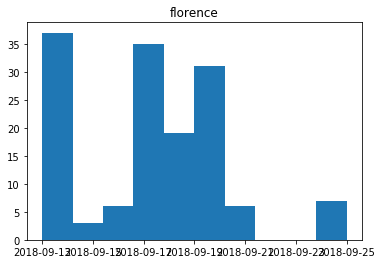

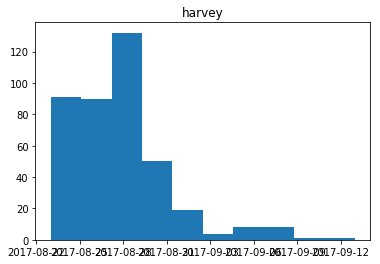

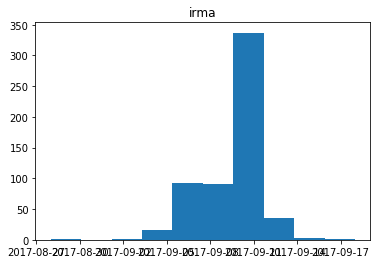

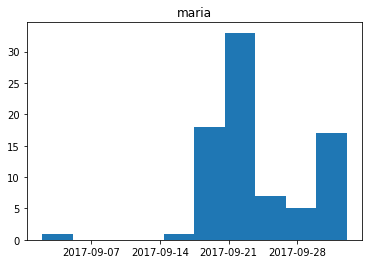

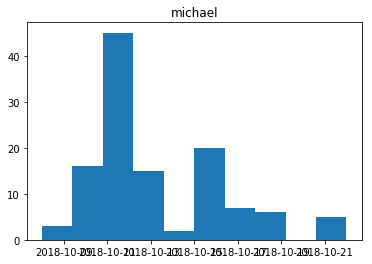

In [63]:
peak_date_var = 'peak_date'
for name_i, data_i in NE_count_peaks.groupby(data_name_var):
    plt.hist(data_i.loc[:, peak_date_var])
    plt.title(name_i)
    plt.show()

Using raw counts, most NEs have peak on same date (except `florence`).

In [11]:
count_var = 'NE_freq'
NE_count_peaks = NE_doc_counts_consistent.groupby([data_name_var, NE_var]).apply(lambda x: assign_peak_date(x, count_var, date_var=round_date_var)).reset_index().rename(columns={0 : 'peak_date'})

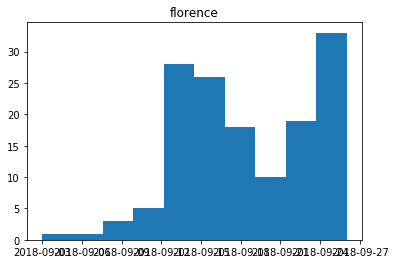

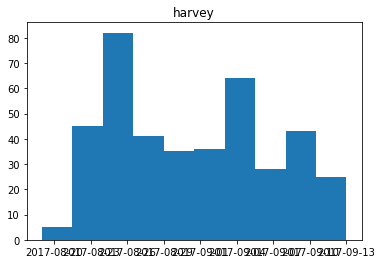

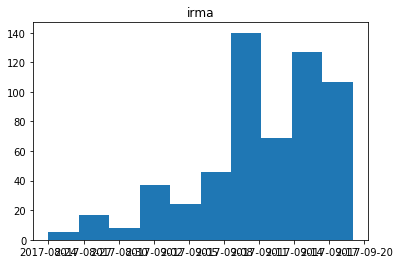

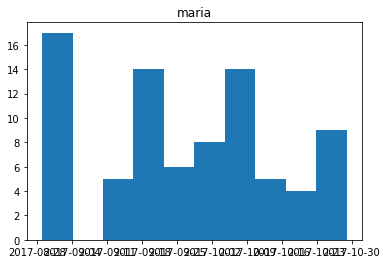

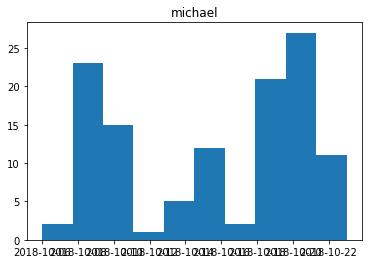

In [66]:
peak_date_var = 'peak_date'
for name_i, data_i in NE_count_peaks.groupby(data_name_var):
    plt.hist(data_i.loc[:, peak_date_var])
    plt.title(name_i)
    plt.show()

More even distribution with normalized frequency => could be less prone to pre/post effect problems.

TODO: determine the relative height of the peaks to neighbor times? Similar to finding minor peaks ex. Mitra et al. (2018) finding minor peaks in collective attention for credibility.

### Re-test pre/post effect
Let's re-test the pre/post peak effect using the peak times from relative frequency.

In [70]:
count_var = 'NE_freq'
NE_count_peaks = NE_doc_counts_consistent.groupby([data_name_var, NE_var]).apply(lambda x: assign_peak_date(x, count_var, date_var=round_date_var)).reset_index().rename(columns={0 : 'peak_date'})

In [71]:
display(NE_count_peaks.head())

,data_name_fixed,NE_fixed,peak_date
0,florence,alert,2018-09-09
1,florence,anson county,2018-09-16
2,florence,apex,2018-09-14
3,florence,asheville,2018-09-16
4,florence,atlanta,2018-09-09


In [72]:
anchor_data_consistent = pd.merge(anchor_data, NE_count_peaks, on=[NE_var, data_name_var], how='inner')
print('%d/%d consistent data'%(anchor_data_consistent.shape[0], anchor_data.shape[0]))

152243/163366 consistent data


Assign pre/during/post peak values, and compare the raw anchor values during those times.

In [81]:
from datetime import timedelta
peak_date_buffer = timedelta(days=1)
peak_date_var = 'peak_date'
round_date_var = 'date_day'
anchor_data_consistent = anchor_data_consistent.assign(**{
    'pre_peak' : (anchor_data_consistent.loc[:, round_date_var] <= anchor_data_consistent.loc[:, peak_date_var] - peak_date_buffer).astype(int),
    'post_peak' : (anchor_data_consistent.loc[:, round_date_var] >= anchor_data_consistent.loc[:, peak_date_var] + peak_date_buffer).astype(int),
})

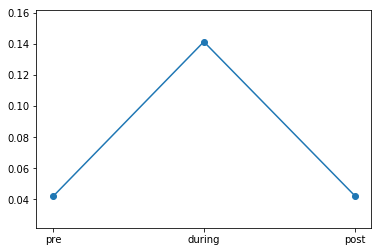

In [160]:
anchor_var = 'anchor'
pre_peak_anchor_mean = (anchor_data_consistent.loc[:, anchor_var] * anchor_data_consistent.loc[:, 'pre_peak']).mean()
post_peak_anchor_mean = (anchor_data_consistent.loc[:, anchor_var] * anchor_data_consistent.loc[:, 'post_peak']).mean()
# during_peak_anchor_mean = (anchor_data_consistent.loc[:, anchor_var] * (1-anchor_data_consistent.loc[:, 'pre_peak']) * (1-anchor_data_consistent.loc[:, 'post_peak'])).mean()
anchor_data_during_peak = anchor_data_consistent[(anchor_data_consistent.loc[:, 'pre_peak']==0) &
                                                 (anchor_data_consistent.loc[:, 'post_peak']==0)]
during_peak_anchor_mean = anchor_data_during_peak.loc[:, 'anchor'].mean()
N = anchor_data_consistent.shape[0]
pre_peak_anchor_sd = (pre_peak_anchor_mean * (1 - pre_peak_anchor_mean) / N)**.5 # SD of Bernouilli
post_peak_anchor_sd = (post_peak_anchor_mean * (1 - post_peak_anchor_mean) / N)**.5
during_peak_anchor_sd = (during_peak_anchor_mean * (1 - during_peak_anchor_mean) / N)**.5
# pre_peak_anchor_sd = (anchor_data_consistent.loc[:, anchor_var] * anchor_data_consistent.loc[:, 'pre_peak']).std()
# post_peak_anchor_sd = (anchor_data_consistent.loc[:, anchor_var] * anchor_data_consistent.loc[:, 'post_peak']).std()
# during_peak_anchor_sd = (anchor_data_consistent.loc[:, anchor_var] * (1-anchor_data_consistent.loc[:, 'pre_peak']) * (1-anchor_data_consistent.loc[:, 'post_peak'])).std()
anchor_means = [pre_peak_anchor_mean, during_peak_anchor_mean, post_peak_anchor_mean]
anchor_err = [pre_peak_anchor_sd, during_peak_anchor_sd, post_peak_anchor_sd]
X = np.arange(len(anchor_means))
plt.scatter(X, anchor_means)
plt.errorbar(X, anchor_means, yerr=anchor_err)
plt.xticks(X, ['pre', 'during', 'post'])
plt.show()

Let's redo this with a bootstrap to make sure the confidence intervals are legit.

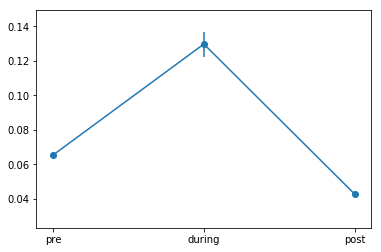

In [167]:
np.random.seed(123)
bootstrap_iters = 100
bootstrap_size = 10000
bootstrap_anchor_means = []
for i in range(bootstrap_iters):
    anchor_var = 'anchor'
    anchor_data_consistent_i = anchor_data_consistent.loc[np.random.choice(anchor_data_consistent.index, size=bootstrap_size, replace=False), :]
    pre_peak_anchor_mean_i = (anchor_data_consistent_i.loc[:, anchor_var] * anchor_data_consistent_i.loc[:, 'pre_peak']).mean()
    post_peak_anchor_mean_i = (anchor_data_consistent_i.loc[:, anchor_var] * anchor_data_consistent_i.loc[:, 'post_peak']).mean()
    anchor_data_during_peak_i = anchor_data_consistent_i[(anchor_data_consistent_i.loc[:, 'pre_peak']==0) &
                                                         (anchor_data_consistent_i.loc[:, 'post_peak']==0)]
    during_peak_anchor_mean_i = anchor_data_during_peak_i.loc[:, 'anchor'].mean()
    bootstrap_anchor_means.append([pre_peak_anchor_mean_i, post_peak_anchor_mean_i, during_peak_anchor_mean_i])
bootstrap_anchor_means = np.vstack(bootstrap_anchor_means)
pre_peak_anchor_mean = np.mean(bootstrap_anchor_means[:, 0].mean())
post_peak_anchor_mean = np.mean(bootstrap_anchor_means[:, 1].mean())
during_peak_anchor_mean = np.mean(bootstrap_anchor_means[:, 2].mean())
# pre_peak_anchor_sd = (pre_peak_anchor_mean * (1 - pre_peak_anchor_mean) / bootstrap_size)**.5 # SE of Bernouilli
# post_peak_anchor_sd = (post_peak_anchor_mean * (1 - post_peak_anchor_mean) / bootstrap_size)**.5
# during_peak_anchor_sd = (during_peak_anchor_mean * (1 - during_peak_anchor_mean) / bootstrap_size)**.5
pre_peak_anchor_sd = np.std(bootstrap_anchor_means[:, 0])
post_peak_anchor_sd = np.std(bootstrap_anchor_means[:, 1])
during_peak_anchor_sd = np.std(bootstrap_anchor_means[:, 2])
anchor_err = [pre_peak_anchor_sd, during_peak_anchor_sd, post_peak_anchor_sd]
X = np.arange(len(anchor_means))
plt.scatter(X, anchor_means)
plt.errorbar(X, anchor_means, yerr=anchor_err)
plt.xticks(X, ['pre', 'during', 'post'])
plt.show()

OK! This time we see a slight decrease in the pre/post periods. Let's see if this persists after randomly permuting the peak dates. This isn't the same as the regression test but it gets at something similar.

Get date ranges to permute.

In [26]:
# first thing: we need all unique dates for NEs
NE_unique_dates = anchor_data_consistent.groupby([data_name_var, NE_var]).apply(lambda x: x.loc[:, round_date_var].unique())
date_range_buffer = 1
NE_date_ranges = anchor_data_consistent.groupby([data_name_var, NE_var]).apply(lambda x: [x.loc[:, round_date_var].min() + timedelta(days=date_range_buffer*i) for i in range(int((x.loc[:, round_date_var].max() - x.loc[:, round_date_var].min()).days / date_range_buffer))])

In [256]:
np.random.seed(123)
permute_iters = 100
anchor_means_permute = []
for i in range(permute_iters):
    # choose random peak date for all NEs
#     NE_peak_dates_i = NE_unique_dates.apply(lambda x: np.random.choice(x, 1)[0]).reset_index().rename(columns={0 : peak_date_var})
    NE_peak_dates_i = NE_date_ranges.apply(lambda x: np.random.choice(x, 1)[0]).reset_index().rename(columns={0 : peak_date_var})
    anchor_data_consistent_i = anchor_data_consistent.drop(peak_date_var, axis=1)
    anchor_data_consistent_i = pd.merge(anchor_data_consistent_i, NE_peak_dates_i, on=[NE_var, data_name_var], how='inner')
    ## reassign pre/post peak
    anchor_data_consistent_i = anchor_data_consistent_i.assign(**{
    'pre_peak' : (anchor_data_consistent_i.loc[:, round_date_var] <= anchor_data_consistent_i.loc[:, peak_date_var] - peak_date_buffer).astype(int),
    'post_peak' : (anchor_data_consistent_i.loc[:, round_date_var] >= anchor_data_consistent_i.loc[:, peak_date_var] + peak_date_buffer).astype(int),
    })
    if(i < 10):
        print('%d/%d/%d pre/during/post'%
              (anchor_data_consistent_i.loc[:, 'pre_peak'].sum(), 
               anchor_data_consistent_i[(anchor_data_consistent_i.loc[:, 'pre_peak']==0) &
                                        (anchor_data_consistent_i.loc[:, 'post_peak']==0)].shape[0],
               anchor_data_consistent_i.loc[:, 'post_peak'].sum()))
    pre_peak_anchor_mean_i = (anchor_data_consistent_i.loc[:, anchor_var] * anchor_data_consistent_i.loc[:, 'pre_peak']).mean()
    post_peak_anchor_mean_i = (anchor_data_consistent_i.loc[:, anchor_var] * anchor_data_consistent_i.loc[:, 'post_peak']).mean()
    anchor_data_during_peak_i = anchor_data_consistent_i[(anchor_data_consistent_i.loc[:, 'pre_peak']==0) &
                                                         (anchor_data_consistent_i.loc[:, 'post_peak']==0)]
    during_peak_anchor_mean_i = anchor_data_during_peak_i.loc[:, 'anchor'].mean()
    anchor_means_permute.append([pre_peak_anchor_mean_i, during_peak_anchor_mean_i, post_peak_anchor_mean_i])
    if(i % 10 == 0):
        print('%d samples'%(i))
anchor_means_permute = np.array(anchor_means_permute)

94059/6390/51794 pre/during/post
0 samples
94172/6219/51852 pre/during/post
87042/10103/55098 pre/during/post
94664/6436/51143 pre/during/post
92971/7607/51665 pre/during/post
92074/6361/53808 pre/during/post
88665/9280/54298 pre/during/post
73430/10959/67854 pre/during/post
108785/5294/38164 pre/during/post
98458/6334/47451 pre/during/post
10 samples
20 samples
30 samples
40 samples
50 samples
60 samples
70 samples
80 samples
90 samples


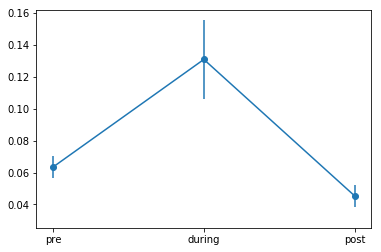

In [257]:
pre_peak_anchor_mean = anchor_means_permute[:, 0].mean()
post_peak_anchor_mean = anchor_means_permute[:, 2].mean()
during_peak_anchor_mean = anchor_means_permute[:, 1].mean()
# pre_peak_anchor_sd = (pre_peak_anchor_mean * (1 - pre_peak_anchor_mean)/ N)**.5 # SD of Bernouilli
# post_peak_anchor_sd = (post_peak_anchor_mean * (1 - post_peak_anchor_mean)/ N)**.5
# during_peak_anchor_sd = (during_peak_anchor_mean * (1 - during_peak_anchor_mean)/ N)**.5
pre_peak_anchor_sd = anchor_means_permute[:, 0].std()
post_peak_anchor_sd = anchor_means_permute[:, 2].std()
during_peak_anchor_sd = anchor_means_permute[:, 1].std()
anchor_means = [pre_peak_anchor_mean, during_peak_anchor_mean, post_peak_anchor_mean]
anchor_err = [pre_peak_anchor_sd, during_peak_anchor_sd, post_peak_anchor_sd]
X = np.arange(len(anchor_means))
plt.scatter(X, anchor_means)
plt.errorbar(X, anchor_means, yerr=anchor_err)
plt.xticks(X, ['pre', 'during', 'post'])
plt.show()

Not good! We see the increase effect even after considering random permutation, although the error bar is bigger.

I guess that this could prove the point about the extreme pre/post periods lacking anchors in general.

This must mean that there is overall more anchoring during the majority of the mid-range of NE periods, and the original peak times were only capturing part of this effect.

### Regression on permuted data
Let's re-run the anchor regression on permuted data. There could be some weird dataset artifacts going on that are worth checking.

In [169]:
## fix rare users
rare_author_var_val = 'RARE_AUTHOR'
author_var = 'username'
data_name_var = 'data_name_fixed'
min_author_count = 5
anchor_data_author_counts = anchor_data_consistent.groupby([data_name_var, author_var]).apply(lambda x: x.shape[0]).reset_index().rename(columns={0 : 'author_count'})
anchor_data_consistent_authors_fixed = pd.merge(anchor_data_consistent, anchor_data_author_counts, on=[data_name_var, author_var])
anchor_data_consistent_authors_fixed = anchor_data_consistent_authors_fixed.assign(**{
    author_var : anchor_data_consistent_authors_fixed.apply(lambda x: x.loc[author_var] if x.loc['author_count'] >= min_author_count else rare_author_var_val, axis=1)
})

In [172]:
## fit L2 regularized model
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod.families.family import Binomial
from statsmodels.genmod.families.links import logit
author_var = 'username'
NE_var = 'NE_fixed'
time_vars = ['pre_peak', 'post_peak']
data_name_var = 'data_name_fixed'
dep_var = 'anchor'
formula = '%s ~ C(%s) + C(%s) + C(%s) + %s'%(dep_var, data_name_var, author_var, NE_var, ' + '.join(time_vars))
## fit full data with best hyperparam in terms of LL
l2_weight = 0.01
max_iter = 100
model_full = GLM.from_formula(formula, anchor_data_consistent_authors_fixed, family=Binomial(link=logit()))
model_res_full = model_full.fit_regularized(maxiter=max_iter, method='elastic_net', alpha=l2_weight, L1_wt=0.0)

In [176]:
import sys
if('..' not in sys.path):
    sys.path.append('..')
from models.model_helpers import compute_err_data
## summary stats
model_res_full_res = compute_err_data(model_res_full)
display(model_res_full_res)

,mean,SE,z_score,p_val,conf_2.5,conf_97.5
Intercept,-0.917082,0.638842,-1.435538,0.039325,-2.169189,0.335025
C(data_name_fixed)[T.harvey],-0.529717,0.079513,-6.662060,0.000000,-0.685559,-0.373876
C(data_name_fixed)[T.irma],-0.619483,0.070608,-8.773605,0.000000,-0.757871,-0.481095
C(data_name_fixed)[T.maria],-0.237787,0.177032,-1.343187,0.071208,-0.584764,0.109189
C(data_name_fixed)[T.michael],0.045364,0.089564,0.506497,0.797534,-0.130178,0.220906
C(username)[T.0406Guno],-0.000523,1.265336,-0.000414,1.000000,-2.480536,2.479489
C(username)[T.10News],0.000101,1.226677,0.000083,1.000000,-2.404142,2.404344
C(username)[T.10NewsWTSP],-0.001357,0.797073,-0.001702,0.999998,-1.563590,1.560877
C(username)[T.11AliveNews],-0.000990,0.850214,-0.001165,0.999999,-1.667380,1.665399
C(username)[T.1200WOAI],-0.000492,1.281016,-0.000384,1.000000,-2.511236,2.510253


OK! With this clean data we have:
- ranking of data sets: `harvey` > `irma`
- `post_peak` < `pre_peak` << `during_peak`

This confirms what we found in the plots above.

Let's run it again with permuted dates and see how the coefficients look this time around.

In [ ]:
np.random.seed(123)
permute_iters = 20
permute_model_results = []
for i in range(permute_iters):
    # choose random peak date for all NEs
#     NE_peak_dates_i = NE_unique_dates.apply(lambda x: np.random.choice(x, 1)[0]).reset_index().rename(columns={0 : peak_date_var})
    NE_peak_dates_i = NE_date_ranges.apply(lambda x: np.random.choice(x, 1)[0]).reset_index().rename(columns={0 : peak_date_var})
    anchor_data_consistent_i = anchor_data_consistent_authors_fixed.drop(peak_date_var, axis=1)
    anchor_data_consistent_i = pd.merge(anchor_data_consistent_i, NE_peak_dates_i, on=[NE_var, data_name_var], how='inner')
    ## reassign pre/post peak
    anchor_data_consistent_i = anchor_data_consistent_i.assign(**{
    'pre_peak' : (anchor_data_consistent_i.loc[:, round_date_var] <= anchor_data_consistent_i.loc[:, peak_date_var] - peak_date_buffer).astype(int),
    'post_peak' : (anchor_data_consistent_i.loc[:, round_date_var] >= anchor_data_consistent_i.loc[:, peak_date_var] + peak_date_buffer).astype(int),
    })
    ## run model
    model_full = GLM.from_formula(formula, anchor_data_consistent_i, family=Binomial(link=logit()))
    model_res_full = model_full.fit_regularized(maxiter=max_iter, method='elastic_net', alpha=l2_weight, L1_wt=0.0)
    permute_model_results.append(model_res_full)

In [260]:
permute_model_coeffs = pd.concat([x.params for x in permute_model_results], axis=1)
permute_model_coeffs_mean = permute_model_coeffs.mean(axis=1)
permute_model_coeffs_sd = permute_model_coeffs.std(axis=1) / (permute_model_coeffs.shape[1]**.5)
# permute_model_coeffs_sd = permute_model_coeffs.std(axis=1)
permute_model_coeffs = pd.concat([permute_model_coeffs_mean, permute_model_coeffs_sd], axis=1).rename(columns={0:'coeff', 1:'SE'})
display(permute_model_coeffs.head())
display(permute_model_coeffs.tail())

,coeff,SE
Intercept,-0.867312,0.005074
C(data_name_fixed)[T.harvey],-0.514763,0.004087
C(data_name_fixed)[T.irma],-0.597574,0.002077
C(data_name_fixed)[T.maria],-0.221414,0.002764
C(data_name_fixed)[T.michael],0.044236,0.001579


,coeff,SE
C(NE_fixed)[T.yoakum],-0.000582,0.000006
C(NE_fixed)[T.youngstown],-0.000832,0.000022
C(NE_fixed)[T.yulee],-0.000046,0.000008
pre_peak,-0.311216,0.022775
post_peak,-0.329861,0.016939


Let's plot the original and permuted coefficients with standard errors.

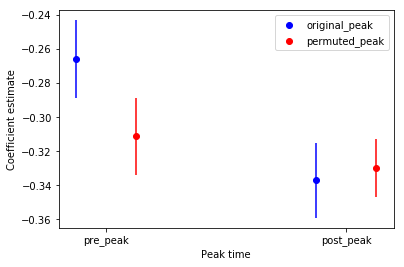

In [261]:
X_offset = 0.125
X = np.array([0,1])
time_vars = ['pre_peak', 'post_peak']
plt.scatter(X-X_offset, model_res_full_res.loc[time_vars, 'mean'], color='b', label='original_peak')
plt.scatter(X+X_offset, permute_model_coeffs.loc[time_vars, 'coeff'], color='r', label='permuted_peak')
plt.errorbar(X-X_offset, model_res_full_res.loc[time_vars, 'mean'], yerr=model_res_full_res.loc[time_vars, 'SE'], linestyle='none', color='b', label=None)
plt.errorbar(X+X_offset, permute_model_coeffs.loc[time_vars, 'coeff'], yerr=permute_model_coeffs.loc[time_vars, 'SE'], linestyle='none', color='r', label=None)
plt.xticks(X, time_vars)
plt.legend(loc='upper right')
plt.xlabel('Peak time')
plt.ylabel('Coefficient estimate')
plt.show()

OK! This confirms what we found before, i.e. a slight decrease in pre/post anchor use regardless of the exact peak time. This may be due to the fact that a NE's automatically determined "peak" time is actually not much greater than other possible peak times (see NE count time series above), which have a similar level of collective attention.

### Permutation test: raw NE frequency

Let's retry this with the peak time assigned by raw frequency.

In [13]:
def assign_peak_date(data, count_var='NE_count', date_var='date_day'):
    max_count = data.loc[:, count_var].max()
    peak_date = data[data.loc[:, count_var] == max_count].loc[:, date_var].iloc[0]
    return peak_date

In [14]:
count_var = 'NE_count'
NE_count_peaks = NE_doc_counts_consistent.groupby([data_name_var, NE_var]).apply(lambda x: assign_peak_date(x, count_var, date_var=round_date_var)).reset_index().rename(columns={0 : 'peak_date'})
anchor_data_consistent = pd.merge(anchor_data, NE_count_peaks, on=[NE_var, data_name_var], how='inner')
print('%d/%d consistent data'%(anchor_data_consistent.shape[0], anchor_data.shape[0]))
from datetime import timedelta
peak_date_buffer = timedelta(days=1)
peak_date_var = 'peak_date'
round_date_var = 'date_day'
anchor_data_consistent = anchor_data_consistent.assign(**{
    'pre_peak' : (anchor_data_consistent.loc[:, round_date_var] <= anchor_data_consistent.loc[:, peak_date_var] - peak_date_buffer).astype(int),
    'post_peak' : (anchor_data_consistent.loc[:, round_date_var] >= anchor_data_consistent.loc[:, peak_date_var] + peak_date_buffer).astype(int),
    'during_peak' : ((anchor_data_consistent.loc[:, round_date_var] > anchor_data_consistent.loc[:, peak_date_var] - peak_date_buffer) & (anchor_data_consistent.loc[:, round_date_var] < anchor_data_consistent.loc[:, peak_date_var] + peak_date_buffer)).astype(int)
})
## fix rare authors
rare_author_var_val = 'RARE_AUTHOR'
author_var = 'username'
data_name_var = 'data_name_fixed'
min_author_count = 5
anchor_data_author_counts = anchor_data_consistent.groupby([data_name_var, author_var]).apply(lambda x: x.shape[0]).reset_index().rename(columns={0 : 'author_count'})
anchor_data_consistent_authors_fixed = pd.merge(anchor_data_consistent, anchor_data_author_counts, on=[data_name_var, author_var])
anchor_data_consistent_authors_fixed = anchor_data_consistent_authors_fixed.assign(**{
    author_var : anchor_data_consistent_authors_fixed.apply(lambda x: x.loc[author_var] if x.loc['author_count'] >= min_author_count else rare_author_var_val, axis=1)
})

152243/163366 consistent data


In [23]:
## fit L2 regularized model
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod.families.family import Binomial
from statsmodels.genmod.families.links import logit
author_var = 'username'
NE_var = 'NE_fixed'
data_name_var = 'data_name_fixed'
dep_var = 'anchor'
time_vars = ['during_peak', 'post_peak']
formula = '%s ~ C(%s) + C(%s) + C(%s) + %s'%(dep_var, data_name_var, author_var, NE_var, ' + '.join(time_vars))
## fit full data with best hyperparam in terms of LL
l2_weight = 0.01
max_iter = 100
model_full = GLM.from_formula(formula, anchor_data_consistent_authors_fixed, family=Binomial(link=logit()))
model_res_full = model_full.fit_regularized(maxiter=max_iter, method='elastic_net', alpha=l2_weight, L1_wt=0.0)

In [24]:
import sys
if('..' not in sys.path):
    sys.path.append('..')
from models.model_helpers import compute_err_data
## summary stats
model_res_full_res = compute_err_data(model_res_full)
display(model_res_full_res)

,mean,SE,z_score,p_val,conf_2.5,conf_97.5
Intercept,-1.022126,0.630935,-1.620017,0.008679,-2.258736,0.214484
C(data_name_fixed)[T.harvey],-0.546092,0.078793,-6.930750,0.000000,-0.700522,-0.391661
C(data_name_fixed)[T.irma],-0.660204,0.069884,-9.447096,0.000000,-0.797175,-0.523233
C(data_name_fixed)[T.maria],-0.249343,0.173338,-1.438475,0.038526,-0.589080,0.090394
C(data_name_fixed)[T.michael],0.035647,0.088750,0.401651,0.871839,-0.138301,0.209594
C(username)[T.0406Guno],-0.000576,1.218021,-0.000473,1.000000,-2.387854,2.386702
C(username)[T.10News],0.000119,1.242452,0.000096,1.000000,-2.435041,2.435280
C(username)[T.10NewsWTSP],-0.001242,0.808853,-0.001536,0.999998,-1.586565,1.584080
C(username)[T.11AliveNews],-0.001052,0.842870,-0.001248,0.999999,-1.653046,1.650942
C(username)[T.1200WOAI],-0.000531,1.241347,-0.000428,1.000000,-2.433526,2.432463


In [15]:
# compute date ranges for every data/NE pair
date_range_buffer = 1
NE_date_ranges = anchor_data_consistent.groupby([data_name_var, NE_var]).apply(lambda x: [x.loc[:, round_date_var].min() + timedelta(days=date_range_buffer*i) for i in range(int((x.loc[:, round_date_var].max() - x.loc[:, round_date_var].min()).days / date_range_buffer))])

In [ ]:
## compare with permuted vars
np.random.seed(123)
permute_iters = 20
permute_model_results = []
permute_data = []
max_iter = 20 #20,50,100 # TODO: test lower max_iter to improve runtime
for i in range(permute_iters):
    # choose random peak date for all NEs
#     NE_peak_dates_i = NE_unique_dates.apply(lambda x: np.random.choice(x, 1)[0]).reset_index().rename(columns={0 : peak_date_var})
    NE_peak_dates_i = NE_date_ranges.apply(lambda x: np.random.choice(x, 1)[0]).reset_index().rename(columns={0 : peak_date_var})
    anchor_data_consistent_i = anchor_data_consistent_authors_fixed.drop(peak_date_var, axis=1)
    anchor_data_consistent_i = pd.merge(anchor_data_consistent_i, NE_peak_dates_i, on=[NE_var, data_name_var], how='inner')
    ## reassign pre/post peak
    anchor_data_consistent_i = anchor_data_consistent_i.assign(**{
        'pre_peak' : (anchor_data_consistent_i.loc[:, round_date_var] <= anchor_data_consistent_i.loc[:, peak_date_var] - peak_date_buffer).astype(int),
        'post_peak' : (anchor_data_consistent_i.loc[:, round_date_var] >= anchor_data_consistent_i.loc[:, peak_date_var] + peak_date_buffer).astype(int),
        'during_peak' : ((anchor_data_consistent_i.loc[:, round_date_var] > anchor_data_consistent_i.loc[:, peak_date_var] - peak_date_buffer) & 
                         (anchor_data_consistent_i.loc[:, round_date_var] < anchor_data_consistent_i.loc[:, peak_date_var] + peak_date_buffer)).astype(int),
    })
    permute_data.append(anchor_data_consistent_i)
    ## run model
    model_full = GLM.from_formula(formula, anchor_data_consistent_i, family=Binomial(link=logit()))
    model_res_full = model_full.fit_regularized(maxiter=max_iter, method='elastic_net', alpha=l2_weight, L1_wt=0.0)
    permute_model_results.append(model_res_full)

In [ ]:
print('blah')

In [ ]:
print('done')

TODO: make sure that the permuted dates are significantly different across permutations.

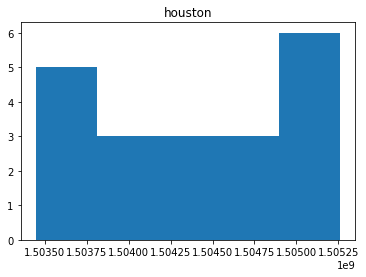

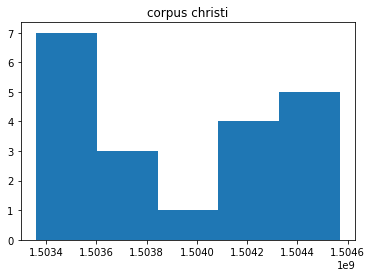

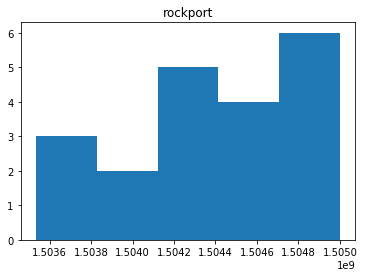

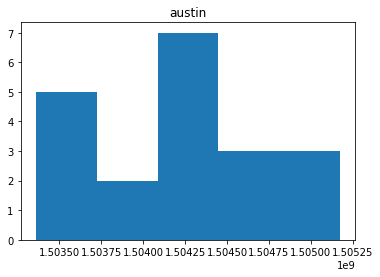

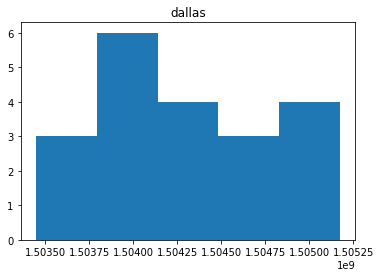

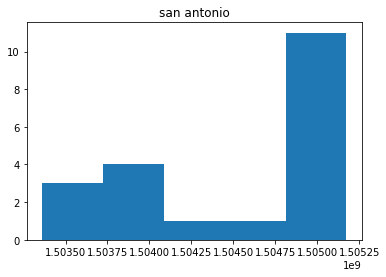

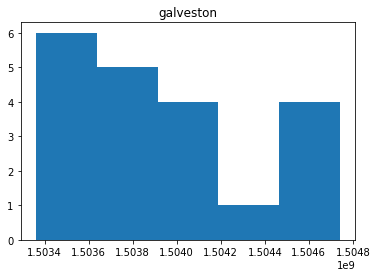

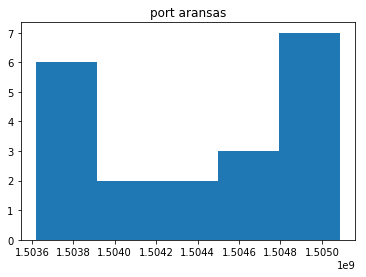

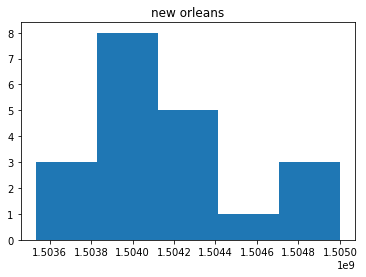

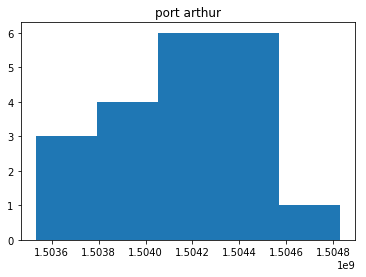

In [29]:
permute_test_data_name = 'harvey'
permute_test_NEs = anchor_data_consistent_authors_fixed[anchor_data_consistent_authors_fixed.loc[:, data_name_var]==permute_test_data_name].loc[:, NE_var].value_counts().index[:10]
for NE_j in permute_test_NEs:
    peak_dates_j = []
    for permute_data_i in permute_data:
        permute_data_i_j = permute_data_i[(permute_data_i.loc[:, NE_var] == NE_j) &
                                          (permute_data_i.loc[:, data_name_var] == permute_test_data_name)]
        peak_date_i = permute_data_i_j.loc[:, 'peak_date'].iloc[0]
        peak_dates_j.append(peak_date_i)
    # show distribution
    plt.hist([x.timestamp() for x in peak_dates_j], bins=5)
    plt.title(NE_j)
    plt.show()

In [31]:
# test the fitted model coefficients
permute_model_coeffs = pd.concat([x.params for x in permute_model_results], axis=1)
permute_model_coeffs_mean = permute_model_coeffs.mean(axis=1)
permute_model_coeffs_sd = permute_model_coeffs.std(axis=1) / (permute_model_coeffs.shape[1]**.5)
# permute_model_coeffs_sd = permute_model_coeffs.std(axis=1)
permute_model_coeffs = pd.concat([permute_model_coeffs_mean, permute_model_coeffs_sd], axis=1).rename(columns={0:'coeff', 1:'SE'})
display(permute_model_coeffs.head())
display(permute_model_coeffs.tail())

,coeff,SE
Intercept,-1.041803,0.008127
C(data_name_fixed)[T.harvey],-0.573779,0.002792
C(data_name_fixed)[T.irma],-0.638296,0.003049
C(data_name_fixed)[T.maria],-0.243290,0.003478
C(data_name_fixed)[T.michael],0.024605,0.002089


,coeff,SE
C(NE_fixed)[T.yoakum],-0.000582,0.000006
C(NE_fixed)[T.youngstown],-0.000851,0.000024
C(NE_fixed)[T.yulee],-0.000065,0.000007
during_peak,0.070751,0.000725
post_peak,-0.166664,0.027289


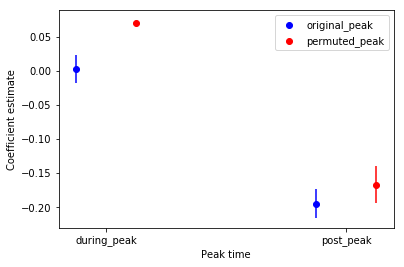

In [32]:
X_offset = 0.125
X = np.array([0,1])
time_vars = ['during_peak', 'post_peak']
plt.scatter(X-X_offset, model_res_full_res.loc[time_vars, 'mean'], color='b', label='original_peak')
plt.scatter(X+X_offset, permute_model_coeffs.loc[time_vars, 'coeff'], color='r', label='permuted_peak')
plt.errorbar(X-X_offset, model_res_full_res.loc[time_vars, 'mean'], yerr=model_res_full_res.loc[time_vars, 'SE'], linestyle='none', color='b', label=None)
plt.errorbar(X+X_offset, permute_model_coeffs.loc[time_vars, 'coeff'], yerr=permute_model_coeffs.loc[time_vars, 'SE'], linestyle='none', color='r', label=None)
plt.xticks(X, time_vars)
plt.legend(loc='upper right')
plt.xlabel('Peak time')
plt.ylabel('Coefficient estimate')
plt.show()

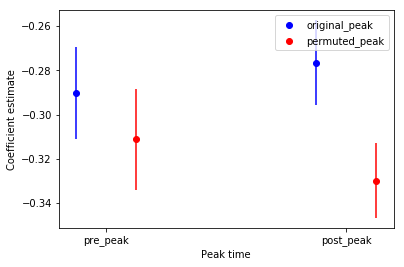

In [275]:
X_offset = 0.125
X = np.array([0,1])
time_vars = ['pre_peak', 'post_peak']
plt.scatter(X-X_offset, model_res_full_res.loc[time_vars, 'mean'], color='b', label='original_peak')
plt.scatter(X+X_offset, permute_model_coeffs.loc[time_vars, 'coeff'], color='r', label='permuted_peak')
plt.errorbar(X-X_offset, model_res_full_res.loc[time_vars, 'mean'], yerr=model_res_full_res.loc[time_vars, 'SE'], linestyle='none', color='b', label=None)
plt.errorbar(X+X_offset, permute_model_coeffs.loc[time_vars, 'coeff'], yerr=permute_model_coeffs.loc[time_vars, 'SE'], linestyle='none', color='r', label=None)
plt.xticks(X, time_vars)
plt.legend(loc='upper right')
plt.xlabel('Peak time')
plt.ylabel('Coefficient estimate')
plt.show()

Well at least we can confirm the earlier results (lower context probability for `post_peak`).

### Add absolute time as control
Maybe the problem with the permutation test is that it's favoring the far end of the time distribution, which has systematically lower P(context). We can control for this by adding an absolute time variable.

In [40]:
import dateutil
from datetime import datetime, timedelta
def fix_timezone(x, date_fmt='%Y-%m-%d %H:%M:%S', timezone_str='+0000'):
    # add timezone offset for "naive" dates
    if(x.utcoffset() is None):
        x = datetime.strptime('%s%s'%(x.strftime(date_fmt), timezone_str), '%s%%z'%(date_fmt))
    return x
def round_to_day(x):
    x_day = datetime(day=x.day, month=x.month, year=x.year)
    return x_day
def assign_peak_date(data, count_var='NE_count', date_var='date_day'):
    max_count = data.loc[:, count_var].max()
    peak_date = data[data.loc[:, count_var] == max_count].loc[:, date_var].iloc[0]
    return peak_date
def load_clean_data():
    # load full data
    full_data = pd.read_csv('../../data/mined_tweets/combined_tweet_tag_data.gz', sep='\t', index_col=False, compression='gzip', converters={'date' : dateutil.parser.parse})
    # load anchor data
    anchor_data = pd.read_csv('../../data/mined_tweets/combined_tweet_tag_data_NE_flat_parsed_anchor.gz', sep='\t', index_col=False, compression='gzip', converters={'date' : dateutil.parser.parse})
    # fix bad usernames
    anchor_data = anchor_data.assign(**{'username' : anchor_data.loc[:, 'username'].apply(lambda x: x.split(':')[-1])})
    date_var = 'date'
    full_data = full_data.assign(**{date_var : full_data.loc[:, date_var].apply(lambda x: fix_timezone(x))})
    anchor_data = anchor_data.assign(**{date_var : anchor_data.loc[:, date_var].apply(lambda x: fix_timezone(x))})
    round_date_var = '%s_day'%(date_var)
    full_data = full_data.assign(**{round_date_var : full_data.loc[:, date_var].apply(lambda x: round_to_day(x))})
    anchor_data = anchor_data.assign(**{round_date_var : anchor_data.loc[:, date_var].apply(lambda x: round_to_day(x))})
    NE_var = 'NE_fixed'
    round_date_var = 'date_day'
    data_name_var = 'data_name_fixed'
    NE_counts = anchor_data.groupby([NE_var, data_name_var, round_date_var]).apply(lambda x: x.shape[0]).reset_index().rename(columns={0 : 'NE_count'})
    id_var = 'id'
    doc_counts = full_data.groupby([data_name_var, round_date_var]).apply(lambda x: x.loc[:, id_var].nunique()).reset_index().rename(columns={0 : 'doc_count'})
    NE_doc_counts = pd.merge(NE_counts, doc_counts, on=[data_name_var, round_date_var])
    NE_doc_counts = NE_doc_counts.assign(**{'NE_freq' : NE_doc_counts.loc[:, 'NE_count'] / NE_doc_counts.loc[:, 'doc_count']})
    k_consistent = 5
    # k_consistent = 10
    NE_unique_date_counts = NE_doc_counts.groupby([data_name_var, NE_var]).apply(lambda x: x.loc[:, round_date_var].nunique())
    NE_consistent = NE_unique_date_counts[NE_unique_date_counts >= k_consistent].reset_index().loc[:, [data_name_var, NE_var]]
    NE_doc_counts_consistent = pd.merge(NE_doc_counts, NE_consistent, on=[data_name_var, NE_var], how='inner')
    count_var = 'NE_count'
    NE_count_peaks = NE_doc_counts_consistent.groupby([data_name_var, NE_var]).apply(lambda x: assign_peak_date(x, count_var, date_var=round_date_var)).reset_index().rename(columns={0 : 'peak_date'})
    anchor_data_consistent = pd.merge(anchor_data, NE_count_peaks, on=[NE_var, data_name_var], how='inner')
    print('%d/%d consistent data'%(anchor_data_consistent.shape[0], anchor_data.shape[0]))
    peak_date_buffer = timedelta(days=1)
    peak_date_var = 'peak_date'
    round_date_var = 'date_day'
    anchor_data_consistent = anchor_data_consistent.assign(**{
        'pre_peak' : (anchor_data_consistent.loc[:, round_date_var] <= anchor_data_consistent.loc[:, peak_date_var] - peak_date_buffer).astype(int),
        'post_peak' : (anchor_data_consistent.loc[:, round_date_var] >= anchor_data_consistent.loc[:, peak_date_var] + peak_date_buffer).astype(int),
        'during_peak' : ((anchor_data_consistent.loc[:, round_date_var] > anchor_data_consistent.loc[:, peak_date_var] - peak_date_buffer) & (anchor_data_consistent.loc[:, round_date_var] < anchor_data_consistent.loc[:, peak_date_var] + peak_date_buffer)).astype(int)
    })
    # add absolute time
    since_start_var = 'data_start'
    data_date_mins = full_data.groupby(data_name_var).apply(lambda x: x.loc[:, round_date_var].min()).reset_index().rename(columns={0 : since_start_var})
    anchor_data_consistent = pd.merge(data_date_mins, anchor_data_consistent, on=data_name_var)
    anchor_data_consistent = anchor_data_consistent.assign(**{
        'since_start' : (anchor_data_consistent.loc[:, round_date_var] - anchor_data_consistent.loc[:, since_start_var]).apply(lambda x: x.days)
    })
    ## fix rare authors
    rare_author_var_val = 'RARE_AUTHOR'
    author_var = 'username'
    data_name_var = 'data_name_fixed'
    min_author_count = 5
    anchor_data_author_counts = anchor_data_consistent.groupby([data_name_var, author_var]).apply(lambda x: x.shape[0]).reset_index().rename(columns={0 : 'author_count'})
    anchor_data_consistent_authors_fixed = pd.merge(anchor_data_consistent, anchor_data_author_counts, on=[data_name_var, author_var])
    anchor_data_consistent_authors_fixed = anchor_data_consistent_authors_fixed.assign(**{
        author_var : anchor_data_consistent_authors_fixed.apply(lambda x: x.loc[author_var] if x.loc['author_count'] >= min_author_count else rare_author_var_val, axis=1)
    })
    return anchor_data_consistent_authors_fixed

In [41]:
anchor_data_consistent_authors_fixed = load_clean_data()

152243/163366 consistent data


In [47]:
## fit L2 regularized model
import sys
if('..' not in sys.path):
    sys.path.append('..')
from models.model_helpers import compute_err_data
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod.families.family import Binomial
from statsmodels.genmod.families.links import logit
from sklearn.preprocessing import StandardScaler
author_var = 'username'
NE_var = 'NE_fixed'
data_name_var = 'data_name_fixed'
dep_var = 'anchor'
time_vars = ['during_peak', 'post_peak', 'since_start']
formula = '%s ~ C(%s) + C(%s) + C(%s) + %s'%(dep_var, data_name_var, author_var, NE_var, ' + '.join(time_vars))
## rescale
scalar_vars = ['since_start']
reg_data = anchor_data_consistent_authors_fixed.copy()
scaler = StandardScaler()
for v in scalar_vars:
    reg_data = reg_data.assign(**{
        v : scaler.fit_transform(reg_data.loc[:, v].values.reshape(-1, 1))
    })
## fit full data with best hyperparam in terms of LL
l2_weight = 0.01
max_iter = 20
model_full = GLM.from_formula(formula, reg_data, family=Binomial(link=logit()))
model_res_full = model_full.fit_regularized(maxiter=max_iter, method='elastic_net', alpha=l2_weight, L1_wt=0.0)
model_res_full_err = compute_err_data(model_res_full)

/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [48]:
display(model_res_full_err)

,mean,SE,z_score,p_val,conf_2.5,conf_97.5
Intercept,-1.032021,0.630177,-1.637669,0.007319,-2.267145,0.203103
C(data_name_fixed)[T.harvey],-0.611951,0.080550,-7.597178,0.000000,-0.769826,-0.454076
C(data_name_fixed)[T.irma],-0.593187,0.072354,-8.198420,0.000000,-0.734998,-0.451376
C(data_name_fixed)[T.maria],-0.205244,0.180932,-1.134374,0.198162,-0.559864,0.149375
C(data_name_fixed)[T.michael],-0.030287,0.097263,-0.311397,0.922752,-0.220919,0.160344
C(username)[T.0406Guno],-0.000562,1.230191,-0.000456,1.000000,-2.411691,2.410568
C(username)[T.10News],0.000122,1.245256,0.000098,1.000000,-2.440535,2.440780
C(username)[T.10NewsWTSP],-0.001233,0.810059,-0.001522,0.999998,-1.588919,1.586454
C(username)[T.11AliveNews],-0.001021,0.847564,-0.001205,0.999999,-1.662215,1.660173
C(username)[T.1200WOAI],-0.000554,1.221193,-0.000453,1.000000,-2.394048,2.392940


Great! So there is an absolute time effect but the `post_peak` effect still holds.

Let's see how this looks with permutation. Ideally the `since_start` effect will hold but the `post_peak` effect will vanish.

In [ ]:
permute_iters = 20
for i in range(permute_iters):
    pass

### Retry with normal logistic regression
Let's see if removing regularization makes things less bad. This could also add back some of the fixed effects that we saw before (ex. "Houston" has lower base rate of context use).

In [ ]:
# reboot data
count_var = 'NE_count'
NE_count_peaks = NE_doc_counts_consistent.groupby([data_name_var, NE_var]).apply(lambda x: assign_peak_date(x, count_var, date_var=round_date_var)).reset_index().rename(columns={0 : 'peak_date'})
anchor_data_consistent = pd.merge(anchor_data, NE_count_peaks, on=[NE_var, data_name_var], how='inner')
print('%d/%d consistent data'%(anchor_data_consistent.shape[0], anchor_data.shape[0]))
from datetime import timedelta
peak_date_buffer = timedelta(days=1)
peak_date_var = 'peak_date'
round_date_var = 'date_day'
anchor_data_consistent = anchor_data_consistent.assign(**{
    'pre_peak' : (anchor_data_consistent.loc[:, round_date_var] <= anchor_data_consistent.loc[:, peak_date_var] - peak_date_buffer).astype(int),
    'post_peak' : (anchor_data_consistent.loc[:, round_date_var] >= anchor_data_consistent.loc[:, peak_date_var] + peak_date_buffer).astype(int),
    'during_peak' : ((anchor_data_consistent.loc[:, round_date_var] > anchor_data_consistent.loc[:, peak_date_var] - peak_date_buffer) & (anchor_data_consistent.loc[:, round_date_var] < anchor_data_consistent.loc[:, peak_date_var] + peak_date_buffer)).astype(int)
})
## fix rare authors
rare_author_var_val = 'RARE_AUTHOR'
author_var = 'username'
data_name_var = 'data_name_fixed'
min_author_count = 5
anchor_data_author_counts = anchor_data_consistent.groupby([data_name_var, author_var]).apply(lambda x: x.shape[0]).reset_index().rename(columns={0 : 'author_count'})
anchor_data_consistent_authors_fixed = pd.merge(anchor_data_consistent, anchor_data_author_counts, on=[data_name_var, author_var])
anchor_data_consistent_authors_fixed = anchor_data_consistent_authors_fixed.assign(**{
    author_var : anchor_data_consistent_authors_fixed.apply(lambda x: x.loc[author_var] if x.loc['author_count'] >= min_author_count else rare_author_var_val, axis=1)
})

### Sanity check: permutation of peak dates
Does the permutation actually produce random dates?

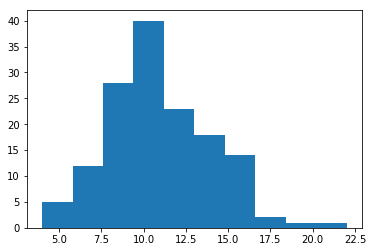

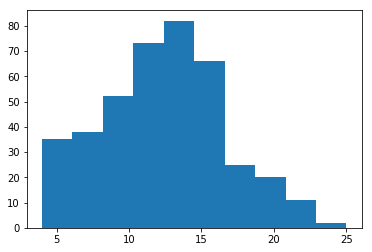

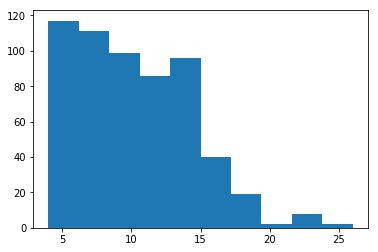

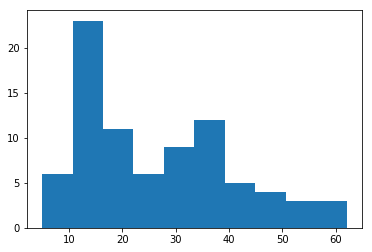

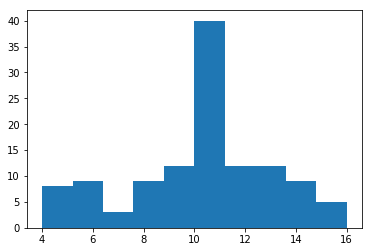

In [18]:
# compute date ranges for every data/NE pair
date_range_buffer = 1
NE_date_ranges = anchor_data_consistent.groupby([data_name_var, NE_var]).apply(lambda x: [x.loc[:, round_date_var].min() + timedelta(days=date_range_buffer*i) for i in range(int((x.loc[:, round_date_var].max() - x.loc[:, round_date_var].min()).days / date_range_buffer))])
# are these date ranges actually that long?
NE_date_ranges_days = NE_date_ranges.apply(len).reset_index().rename(columns={0 : 'date_range_len'})
for name_i, data_i in NE_date_ranges_days.groupby(data_name_var):
    plt.hist(data_i.loc[:, 'date_range_len'])
    plt.show()

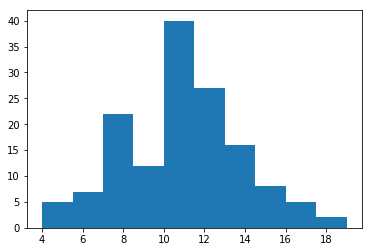

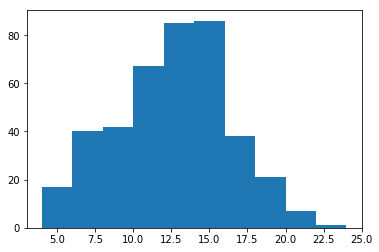

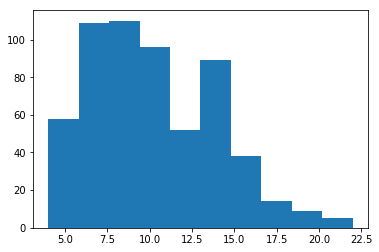

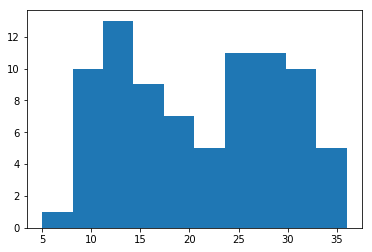

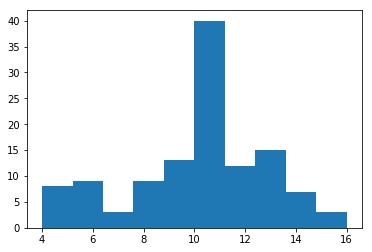

In [36]:
permute_iters = 50
permute_peak_dates = []
for i in range(permute_iters):
    NE_peak_dates_i = NE_date_ranges.apply(lambda x: np.random.choice(x, 1)[0])
    permute_peak_dates.append(NE_peak_dates_i)
permute_peak_dates = pd.concat(permute_peak_dates, axis=1)
permuted_dates = permute_peak_dates.reset_index().assign(**{'date_range_len' : permuted_dates.loc[:, [x for x in list(range(permute_iters))]].apply(lambda x: len(set(x)), axis=1)})
for name_i, data_i in permuted_dates.groupby(data_name_var):
    plt.hist(data_i.loc[:, 'date_range_len'])
    plt.show()

Confirmed! The sampling reproduces the original date distribution.

### Plot original and permuted coefficients for time variables
Having computed the coefficients for the anchor regression for the original and date-permuted data, we now plot them side by side for comparison.

In [1]:
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
reg_results_original = pd.read_csv('../../output/anchor_regularized_logit_output_anchor~C(data_name_fixed)+C(username)+C(NE_fixed)+txt_len_norm+since_start+during_peak+post_peak+has_URL.tsv', sep='\t', index_col=0)
reg_results_permute = pd.read_csv('../../output/permute_anchor_regularized_logit_output_anchor~C(data_name_fixed)+C(username)+C(NE_fixed)+txt_len_norm+since_start+during_peak+post_peak+has_URL.tsv', sep='\t', index_col=0)

In [6]:
# correct standard error
permute_iter = 20
se_mult = permute_iter**.5
reg_results_permute = reg_results_permute.assign(**{
    'err' : reg_results_permute.loc[:, 'err'] * se_mult
})

In [8]:
print(reg_results_permute.columns)

Index(['estimate', 'err'], dtype='object')


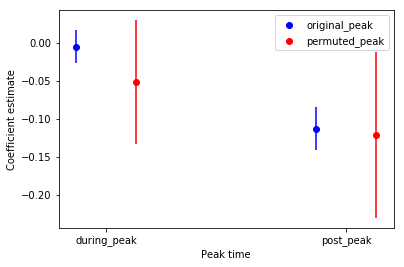

In [10]:
X_offset = 0.125
X = np.array([0,1])
time_vars = ['during_peak', 'post_peak']
plt.scatter(X-X_offset, reg_results_original.loc[time_vars, 'mean'], color='b', label='original_peak')
plt.scatter(X+X_offset, reg_results_permute.loc[time_vars, 'estimate'], color='r', label='permuted_peak')
plt.errorbar(X-X_offset, reg_results_original.loc[time_vars, 'mean'], yerr=reg_results_original.loc[time_vars, 'SE'], linestyle='none', color='b', label=None)
plt.errorbar(X+X_offset, reg_results_permute.loc[time_vars, 'estimate'], yerr=reg_results_permute.loc[time_vars, 'err'], linestyle='none', color='r', label=None)
plt.xticks(X, time_vars)
plt.legend(loc='upper right')
plt.xlabel('Peak time')
plt.ylabel('Coefficient estimate')
plt.show()

If we assume that the standard errors are correct, then the decrease effect is much less than before.